In [6]:
import numpy as np
import glob
import os
import pandas as pd

def build_lstm_sequences_with_ids_and_seasonality_dual(
    no_fire_folder, fire_folder, sequence_length=12, target_column="chla_mean"
):
    """
    Builds LSTM sequences from two folders: no-fire and fire lakes.
    Adds seasonality (week_sin, week_cos), tracks Lake_ID.
    Filters out any sequence with NaNs.
    Returns separate X/y/lake_ids for both groups.
    """

    def process_folder(folder):
        X_all, y_all, lake_ids = [], [], []

        for file in glob.glob(os.path.join(folder, "Lake_*.csv")):
            df = pd.read_csv(file)
            lake_id = int(df["Lake_ID"].iloc[0])

            # Add seasonal features
            df['week_sin'] = np.sin(2 * np.pi * df['Week'] / 52)
            df['week_cos'] = np.cos(2 * np.pi * df['Week'] / 52)

            # Define predictors (exclude metadata and target)
            predictors = df.columns.difference([
                "Lake_ID", "Year", "Week", "week", "week_start", "week_end", target_column
            ])
            values = df[predictors].values
            targets = df[target_column].values

            for i in range(len(df) - sequence_length + 1):
                x_seq = values[i:i+sequence_length]
                y_val = targets[i+sequence_length - 1]

                if np.isnan(x_seq).any() or np.isnan(y_val):
                    continue

                X_all.append(x_seq)
                y_all.append(y_val)
                lake_ids.append(lake_id)

        return np.array(X_all), np.array(y_all), np.array(lake_ids)

    X_no_fire, y_no_fire, ids_no_fire = process_folder(no_fire_folder)
    X_fire, y_fire, ids_fire = process_folder(fire_folder)

    print(f"✅ No-Fire: {len(X_no_fire)} sequences | Fire: {len(X_fire)} sequences")
    return (X_no_fire, y_no_fire, ids_no_fire), (X_fire, y_fire, ids_fire)


In [7]:
(no_fire_X, no_fire_y, no_fire_ids), (fire_X, fire_y, fire_ids) = build_lstm_sequences_with_ids_and_seasonality_dual(
    no_fire_folder="Datasets/No_Fire_With_FirePredictors",
    fire_folder="Datasets/Fire_With_FirePredictors",
    sequence_length=5
)


✅ No-Fire: 214823 sequences | Fire: 60167 sequences


In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os

def normalize_split_with_target_scaling_dual(
    X, y, lake_ids, test_size=0.2, output_dir="lstm_numpy"
):
    """
    Normalizes predictors and standardizes target (CHLA).
    Remaps Lake_IDs, splits train/test, saves to disk.
    """

    # Remap Lake_IDs to contiguous integers
    unique_ids = np.unique(lake_ids)
    id_map = {orig_id: new_id for new_id, orig_id in enumerate(unique_ids)}
    mapped_ids = np.array([id_map[i] for i in lake_ids])

    # Normalize predictors
    n_timesteps, n_features = X.shape[1], X.shape[2]
    X_flat = X.reshape(-1, n_features)
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X_flat).reshape(-1, n_timesteps, n_features)

    # Standardize CHLA target
    y = y.reshape(-1, 1)
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y).ravel()

    # Split into train/test
    X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
        X_scaled, y_scaled, mapped_ids, test_size=test_size, shuffle=True, random_state=42
    )

    # Save to .npy files
    os.makedirs(output_dir, exist_ok=True)
    np.save(os.path.join(output_dir, "X_train.npy"), X_train)
    np.save(os.path.join(output_dir, "X_test.npy"), X_test)
    np.save(os.path.join(output_dir, "y_train.npy"), y_train)
    np.save(os.path.join(output_dir, "y_test.npy"), y_test)
    np.save(os.path.join(output_dir, "lake_ids_train.npy"), ids_train)
    np.save(os.path.join(output_dir, "lake_ids_test.npy"), ids_test)

    print(f"✅ Saved standardized data to: {output_dir}/")
    print(f"Train shape: {X_train.shape}, Target std: mean={y.mean():.2f}, std={y.std():.2f}")
    return X_train, X_test, y_train, y_test, ids_train, ids_test, scaler_X, scaler_y, id_map



# Save Fire data
X_train_f, X_test_f, y_train_f, y_test_f, ids_train_f, ids_test_f, scaler_X_f, scaler_y_f, id_map_f = normalize_split_with_target_scaling_dual(
    X=fire_X,
    y=fire_y,
    lake_ids=fire_ids,
    output_dir="Datasets/LSTM2_Fire"
)

# Save No-Fire data
X_train_nf, X_test_nf, y_train_nf, y_test_nf, ids_train_nf, ids_test_nf, scaler_X_nf, scaler_y_nf, id_map_nf = normalize_split_with_target_scaling_dual(
    X=no_fire_X,
    y=no_fire_y,
    lake_ids=no_fire_ids,
    output_dir="Datasets/LSTM2_NoFire"
)


✅ Saved standardized data to: Datasets/LSTM2_Fire/
Train shape: (48133, 5, 23), Target std: mean=15.03, std=10.79
✅ Saved standardized data to: Datasets/LSTM2_NoFire/
Train shape: (171858, 5, 23), Target std: mean=12.90, std=9.65


In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import os

def train_balanced_lstm_with_metadata(
    fire_folder,
    no_fire_folder,
    model_save_path="model_fire_no_fire_balanced.pth",
    num_epochs=20,
    batch_size=64,
    emb_dim=16,
    hidden_size=64
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    def load_split(folder, prefix):
        X = np.load(os.path.join(folder, f"X_{prefix}.npy"))
        y = np.load(os.path.join(folder, f"y_{prefix}.npy"))
        ids = np.load(os.path.join(folder, f"lake_ids_{prefix}.npy"))
        return X, y, ids

    # 🔹 Load training data from both sets
    X_f, y_f, ids_f = load_split(fire_folder, "train")
    X_nf, y_nf, ids_nf = load_split(no_fire_folder, "train")

    min_size = min(len(X_f), len(X_nf))
    idx_f = np.random.choice(len(X_f), min_size, replace=False)
    idx_nf = np.random.choice(len(X_nf), min_size, replace=False)

    X_train = np.concatenate([X_f[idx_f], X_nf[idx_nf]])
    y_train = np.concatenate([y_f[idx_f], y_nf[idx_nf]])
    ids_train = np.concatenate([ids_f[idx_f], ids_nf[idx_nf]])

    # 🔹 Use fire dataset for testing
    X_test, y_test, ids_test = load_split(fire_folder, "test")

    # 🔹 Convert to tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    ids_train_t = torch.tensor(ids_train, dtype=torch.long)

    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    ids_test_t = torch.tensor(ids_test, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(X_train_t, ids_train_t, y_train_t), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_t, ids_test_t, y_test_t), batch_size=batch_size, shuffle=False)

    # 🔹 Model definition
    class LSTMWithLakeEmbeddingFusion(nn.Module):
        def __init__(self, input_size, num_lakes, emb_dim=16, hidden_size=64, num_layers=2):
            super().__init__()
            self.embedding = nn.Embedding(num_lakes, emb_dim)
            self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=num_layers)
            self.fc_lstm = nn.Linear(hidden_size, 32)
            self.fc_emb = nn.Linear(emb_dim, 16)
            self.final = nn.Linear(48, 1)

        def forward(self, x, lake_id):
            lstm_out, _ = self.lstm(x)
            last = lstm_out[:, -1, :]
            lake_emb = self.embedding(lake_id)
            lstm_feat = torch.relu(self.fc_lstm(last))
            lake_feat = torch.relu(self.fc_emb(lake_emb))
            return self.final(torch.cat([lstm_feat, lake_feat], dim=1))

    input_size = X_train.shape[2]
    num_lakes = int(max(ids_train.max(), ids_test.max())) + 1

    model = LSTMWithLakeEmbeddingFusion(input_size, num_lakes, emb_dim, hidden_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for xb, lidb, yb in train_loader:
            xb, lidb, yb = xb.to(device), lidb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb, lidb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss / len(train_loader.dataset):.4f}")

    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    torch.save({
        "model_state_dict": model.state_dict(),
        "input_size": input_size,
        "num_lakes": num_lakes,
        "emb_dim": emb_dim,
        "hidden_size": hidden_size
    }, model_save_path)
    print(f"✅ Model and metadata saved to: {model_save_path}")
    return model, test_loader, device



model, test_loader, device = train_balanced_lstm_with_metadata(
    fire_folder="Datasets/LSTM2_Fire",
    no_fire_folder="Datasets/LSTM2_NoFire",
    model_save_path="Datasets/LSTM_Combined/trained_models/chla_lstm_fire_and_no_fire.pth"
)


Using device: cuda
Epoch 1/20 - Loss: 0.6903
Epoch 2/20 - Loss: 0.5682
Epoch 3/20 - Loss: 0.5439
Epoch 4/20 - Loss: 0.5320
Epoch 5/20 - Loss: 0.5230
Epoch 6/20 - Loss: 0.5154
Epoch 7/20 - Loss: 0.5087
Epoch 8/20 - Loss: 0.5034
Epoch 9/20 - Loss: 0.4988
Epoch 10/20 - Loss: 0.4947
Epoch 11/20 - Loss: 0.4905
Epoch 12/20 - Loss: 0.4876
Epoch 13/20 - Loss: 0.4835
Epoch 14/20 - Loss: 0.4806
Epoch 15/20 - Loss: 0.4779
Epoch 16/20 - Loss: 0.4745
Epoch 17/20 - Loss: 0.4722
Epoch 18/20 - Loss: 0.4698
Epoch 19/20 - Loss: 0.4668
Epoch 20/20 - Loss: 0.4640
✅ Model and metadata saved to: Datasets/LSTM_Combined/trained_models/chla_lstm_fire_and_no_fire.pth


In [14]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
import os

# Load your local files
X_fire = np.load("Datasets/LSTM2_Fire/X_train.npy")
y_fire = np.load("Datasets/LSTM2_Fire/y_train.npy")

X_nofire = np.load("Datasets/LSTM2_NoFire/X_train.npy")
y_nofire = np.load("Datasets/LSTM2_NoFire/y_train.npy")

# Combine targets
y_combined = np.concatenate([y_fire, y_nofire], axis=0)

# Fit scaler
scaler_y_combined = StandardScaler()
scaler_y_combined.fit(y_combined.reshape(-1, 1))

# Save it
os.makedirs("Datasets/LSTM2_Combined", exist_ok=True)
joblib.dump(scaler_y_combined, "Datasets/LSTM_Combined/scaler_y_combined.pkl")

print("✅ scaler_y_combined saved to Datasets/LSTM_Combined/scaler_y_combined.pkl")


✅ scaler_y_combined saved to Datasets/LSTM_Combined/scaler_y_combined.pkl


C:\Users\moein\AppData\Local\Temp\ipykernel_28528\3301156774.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


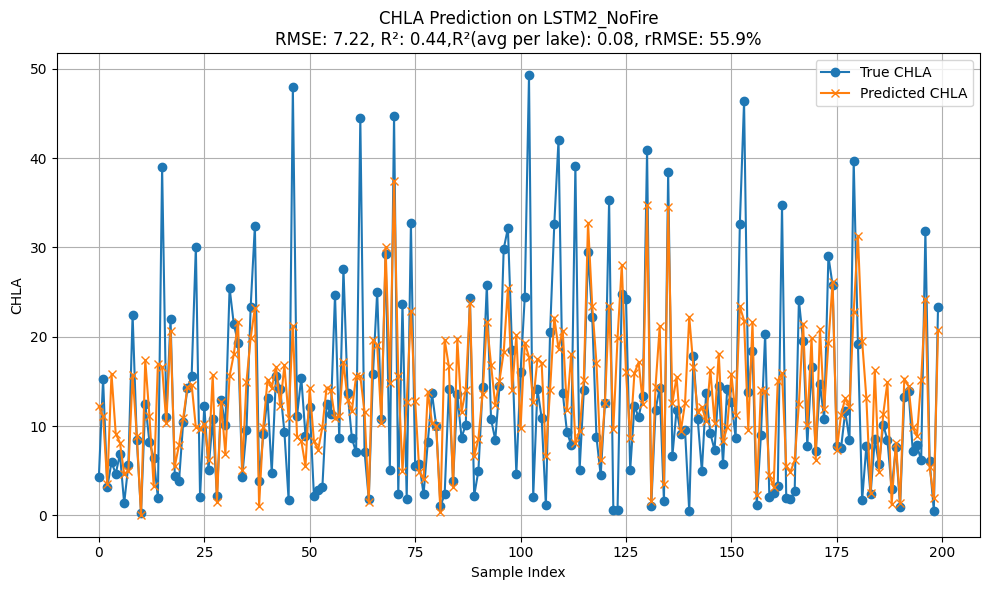

C:\Users\moein\AppData\Local\Temp\ipykernel_28528\3301156774.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


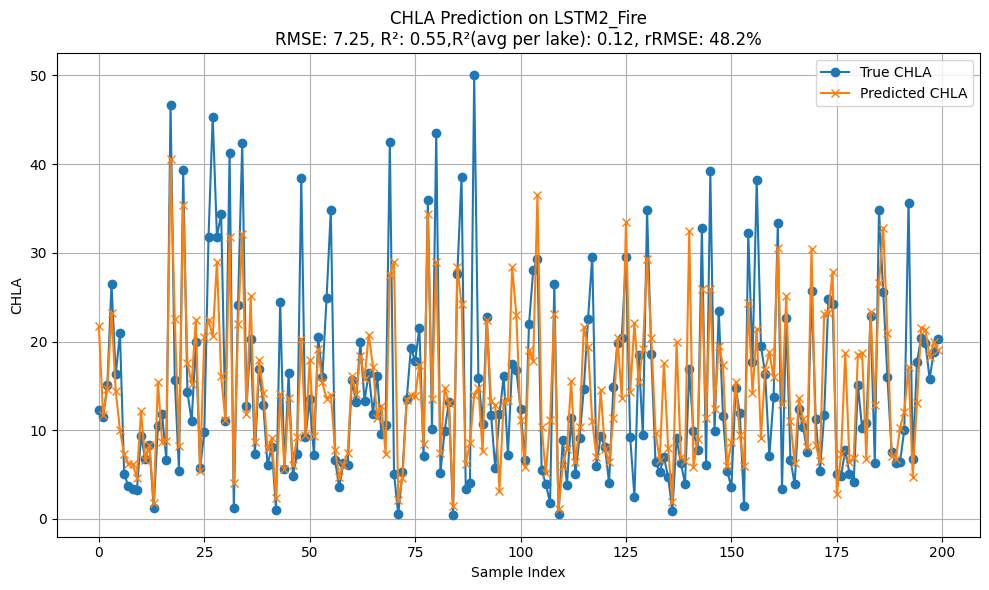

(np.float64(7.249267804234423),
 0.551677942276001,
 np.float64(48.15491707196144))

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import os






def evaluate_model_on_test_set(model_path, test_data_folder, scaler_y, batch_size=64, max_batches=None):
    # Load test data
    X_test = np.load(os.path.join(test_data_folder, "X_test.npy"))
    y_test = np.load(os.path.join(test_data_folder, "y_test.npy"))
    lake_ids_test = np.load(os.path.join(test_data_folder, "lake_ids_test.npy"))

    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    lake_ids_test_t = torch.tensor(lake_ids_test, dtype=torch.long)

    test_loader = DataLoader(
        TensorDataset(X_test_t, lake_ids_test_t, y_test_t),
        batch_size=batch_size, shuffle=False
    )

    # Device setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load model checkpoint and architecture
    checkpoint = torch.load(model_path)
    input_size = checkpoint["input_size"]
    num_lakes = checkpoint["num_lakes"]
    emb_dim = checkpoint["emb_dim"]
    hidden_size = checkpoint["hidden_size"]

    class LSTMWithLakeEmbeddingFusion(torch.nn.Module):
        def __init__(self, input_size, num_lakes, emb_dim=16, hidden_size=64, num_layers=2):
            super().__init__()
            self.embedding = torch.nn.Embedding(num_lakes, emb_dim)
            self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
            self.fc_lstm = torch.nn.Linear(hidden_size, 32)
            self.fc_emb = torch.nn.Linear(emb_dim, 16)
            self.final = torch.nn.Linear(48, 1)

        def forward(self, x, lake_id):
            lstm_out, _ = self.lstm(x)
            last_hidden = lstm_out[:, -1, :]
            lake_emb = self.embedding(lake_id)
            lstm_feat = torch.relu(self.fc_lstm(last_hidden))
            emb_feat = torch.relu(self.fc_emb(lake_emb))
            return self.final(torch.cat([lstm_feat, emb_feat], dim=1))

    model = LSTMWithLakeEmbeddingFusion(input_size, num_lakes, emb_dim, hidden_size).to(device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    # Prediction
    all_preds, all_targets = [], []
    with torch.no_grad():
        for i, (xb, lidb, yb) in enumerate(test_loader):
            xb, lidb, yb = xb.to(device), lidb.to(device), yb.to(device)
            preds = model(xb, lidb)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(yb.cpu().numpy())
            if max_batches and i >= max_batches:
                break

    preds_scaled = np.concatenate(all_preds)
    targets_scaled = np.concatenate(all_targets)

    # Inverse transform CHLA
    preds_original = scaler_y.inverse_transform(preds_scaled)
    targets_original = scaler_y.inverse_transform(targets_scaled)

    # Metrics
    rmse = np.sqrt(mean_squared_error(targets_original, preds_original))
    r2 = r2_score(targets_original, preds_original)
    rrmse = (rmse / np.mean(targets_original)) * 100

    # ✅ Per-lake R² (new)
    def compute_average_per_lake_r2(y_true, y_pred, lake_ids):
        unique_lakes = np.unique(lake_ids)
        r2s = []

        for lake_id in unique_lakes:
            idx = lake_ids == lake_id
            if np.sum(idx) > 1:  # Need at least 2 samples
                r2_lake = r2_score(y_true[idx], y_pred[idx])
                r2s.append(r2_lake)

        return np.mean(r2s), r2s

    avg_r2_per_lake, per_lake_r2_list = compute_average_per_lake_r2(
        targets_original, preds_original, lake_ids_test
    )



    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(targets_original[:200], label="True CHLA", marker="o")
    plt.plot(preds_original[:200], label="Predicted CHLA", marker="x")
    plt.title(f"CHLA Prediction on {os.path.basename(test_data_folder)}\nRMSE: {rmse:.2f}, R²: {r2:.2f},R²(avg per lake): {avg_r2_per_lake:.2f}, rRMSE: {rrmse:.1f}%")
    plt.xlabel("Sample Index")
    plt.ylabel("CHLA")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return rmse, r2, rrmse


# Evaluate on No-Fire lakes using the fire+no-fire trained model
evaluate_model_on_test_set(
    model_path="Datasets/LSTM_Combined/trained_models/chla_lstm_fire_and_no_fire.pth",
    test_data_folder="Datasets/LSTM2_NoFire",
    scaler_y=scaler_y_nf
)

# Evaluate on Fire lakes using the same model
evaluate_model_on_test_set(
    model_path="Datasets/LSTM_Combined/trained_models/chla_lstm_fire_and_no_fire.pth",
    test_data_folder="Datasets/LSTM2_Fire",
    scaler_y=scaler_y_f
)


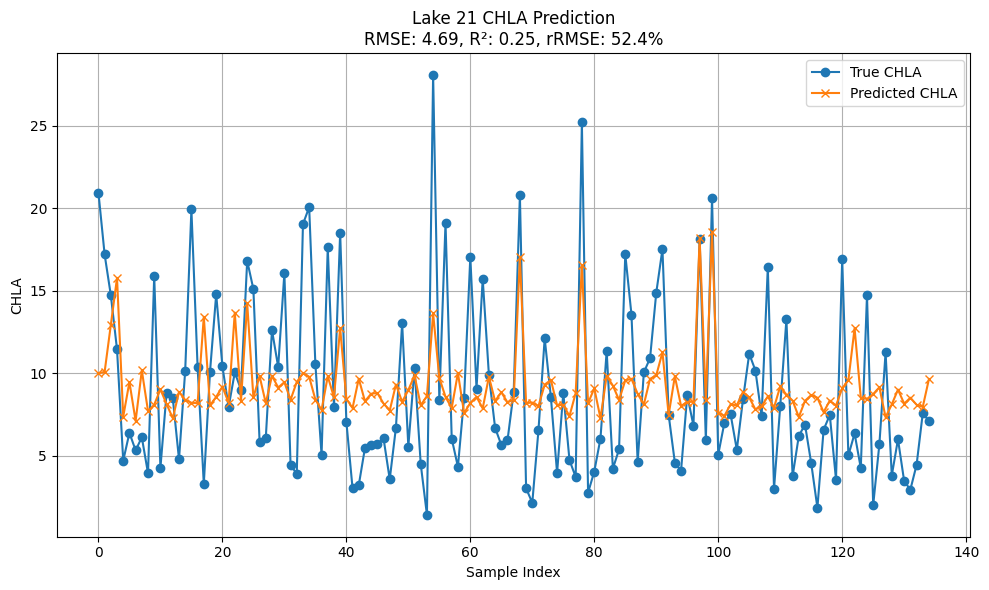

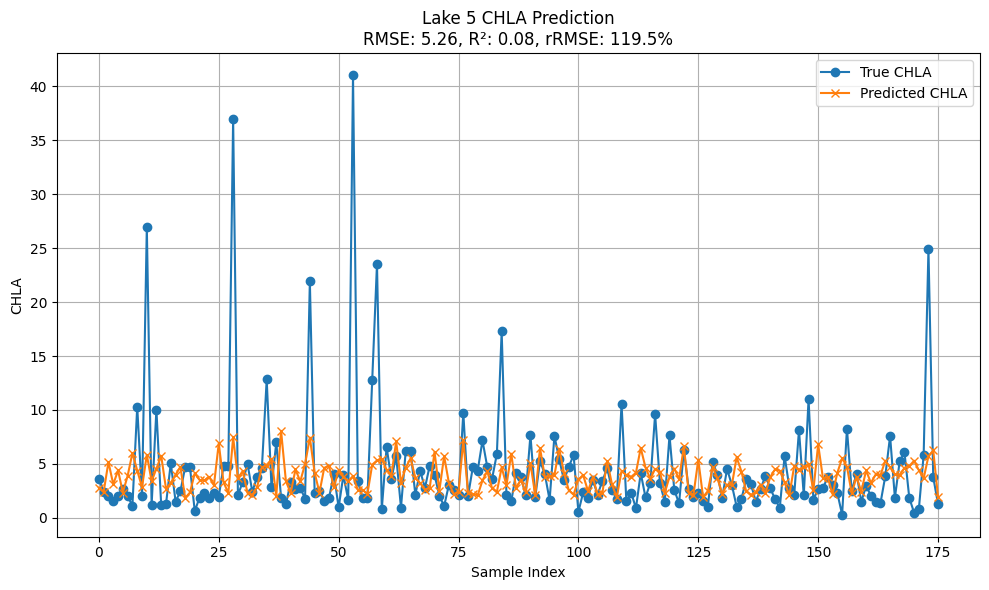

In [21]:
def plot_lake_predictions_with_rrmse(
    lake_original_id, model, X_test, y_test, lake_ids_test, id_map, scaler_y, device
):
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error, r2_score
    import numpy as np
    import torch

    model.eval()

    # Map original Lake_ID to internal remapped index
    lake_index = id_map.get(lake_original_id)
    if lake_index is None:
        print(f"❌ Lake ID {lake_original_id} not found in id_map.")
        return

    # Extract samples for this lake
    indices = np.where(lake_ids_test == lake_index)[0]
    if len(indices) == 0:
        print(f"⚠️ No test samples found for Lake ID {lake_original_id}.")
        return

    X_lake = torch.tensor(X_test[indices], dtype=torch.float32).to(device)
    lake_ids_tensor = torch.tensor([lake_index] * len(indices), dtype=torch.long).to(device)
    y_true_scaled = y_test[indices]

    with torch.no_grad():
        y_pred_scaled = model(X_lake, lake_ids_tensor).cpu().numpy()

    # Inverse scaling
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    y_true = scaler_y.inverse_transform(y_true_scaled.reshape(-1, 1)).ravel()

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    rrmse = (rmse / y_true.mean()) * 100

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label="True CHLA", marker='o')
    plt.plot(y_pred, label="Predicted CHLA", marker='x')
    plt.title(f"Lake {lake_original_id} CHLA Prediction\nRMSE: {rmse:.2f}, R²: {r2:.2f}, rRMSE: {rrmse:.1f}%")
    plt.xlabel("Sample Index")
    plt.ylabel("CHLA")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return rmse, r2, rrmse







rmse, r2, rrmse = plot_lake_predictions_with_rrmse(
    lake_original_id=21,                # Change to any lake ID you want
    model=model,
    X_test=X_test_f,
    y_test=y_test_f,
    lake_ids_test=ids_test_f,
    id_map=id_map_f,
    scaler_y=scaler_y_f,
    device=device
)



rmse, r2, rrmse = plot_lake_predictions_with_rrmse(
    lake_original_id=5,
    model=model,
    X_test=X_test_nf,
    y_test=y_test_nf,
    lake_ids_test=ids_test_nf,
    id_map=id_map_nf,
    scaler_y=scaler_y_nf,
    device=device
)
